# 5 AutoGen - Enabling LLM-powered agents to cooperate

AutoGen is a framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. AutoGen agents are customizable, conversable, and seamlessly allow human participation. They can operate in various modes that employ combinations of LLMs, human inputs, and tools.

31/05/2024

<img src="https://raw.githubusercontent.com/retkowsky/images/master/autogenlogo.jpg">

> Documentation: https://microsoft.github.io/autogen/

In [1]:
import autogen
import openai
import os
import sys

from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from getpass import getpass
from IPython.display import Markdown, display
from PIL import Image

In [2]:
sys.version

'3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]'

In [3]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [4]:
check_openai_version()

Installed OpenAI version: 1.30.5
[OK] OpenAI version 1.30.5 is >= 1.0.0


In [5]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    #filter_dict={"tags": ["gpt-4"]},  # comment out to get all
)
# When using a single openai endpoint, you can use the following:
# config_list = [{"model": "gpt-4", "api_key": os.getenv("OPENAI_API_KEY")}]

In [6]:
WORK_DIR = "workdir"

os.makedirs(WORK_DIR, exist_ok=True)

## 1. Agent

In [7]:
config_list = config_list_from_json(env_or_file="OAI_CONFIG_LIST")

In [8]:
assistant = AssistantAgent(
    "assistant",
    llm_config={
        "cache_seed": None,
        "config_list": config_list,
        "temperature": 0,
    },
)

user_proxy = UserProxyAgent("user_proxy",
                            human_input_mode="NEVER",
                            code_execution_config={"work_dir": WORK_DIR})

user_proxy.initiate_chat(
    assistant,
    message=
    "Generate a plot of the APPLE company stocks from the last 30 days and save it \
in the script folder with the 'apple.png' filename")

user_proxy (to assistant):

Generate a plot of the APPLE company stocks from the last 30 days and save it in the script folder with the 'apple.png' filename

--------------------------------------------------------------------------------
assistant (to user_proxy):

To generate a plot of the APPLE company stocks from the last 30 days, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance, which we can then plot using the `matplotlib` library.

Here is the Python code to do this:

```python
# filename: plot_apple_stock.py

import yfinance as yf
import matplotlib.pyplot as plt

# Download the APPLE stock data for the last 30 days
data = yf.download('AAPL', period='1mo')

# Plot the Close price
data['Close'].plot()

# Set the title and labels
plt.title('APPLE Stock Price - Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')

# Save the plot as a PNG file
plt.savefig('apple.png')
```

To run this script, you need to have `yfinance` 


--------------------------------------------------------------------------------
assistant (to user_proxy):

Great! The script has successfully executed and the required modules 'yfinance' and 'matplotlib' have been installed. The script has also downloaded the APPLE stock data for the last 30 days, generated a plot of the closing prices, and saved it as 'apple.png' in the same directory as the script.

You can verify this by checking the directory where the script was run. You should see a file named 'apple.png'. This file is the plot of the APPLE stock prices for the last 30 days.

TERMINATE

--------------------------------------------------------------------------------
user_proxy (to assistant):



--------------------------------------------------------------------------------
assistant (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Generate a plot of the APPLE company stocks from the last 30 days and save it in the script folder with the 'apple.png' filename", 'role': 'assistant'}, {'content': "To generate a plot of the APPLE company stocks from the last 30 days, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance, which we can then plot using the `matplotlib` library.\n\nHere is the Python code to do this:\n\n```python\n# filename: plot_apple_stock.py\n\nimport yfinance as yf\nimport matplotlib.pyplot as plt\n\n# Download the APPLE stock data for the last 30 days\ndata = yf.download('AAPL', period='1mo')\n\n# Plot the Close price\ndata['Close'].plot()\n\n# Set the title and labels\nplt.title('APPLE Stock Price - Last 30 Days')\nplt.xlabel('Date')\nplt.ylabel('Price')\n\n# Save the plot as a PNG file\nplt.savefig('apple.png')\n```\n\nTo run this script, you need to have `yfinance` and `matplotlib` install

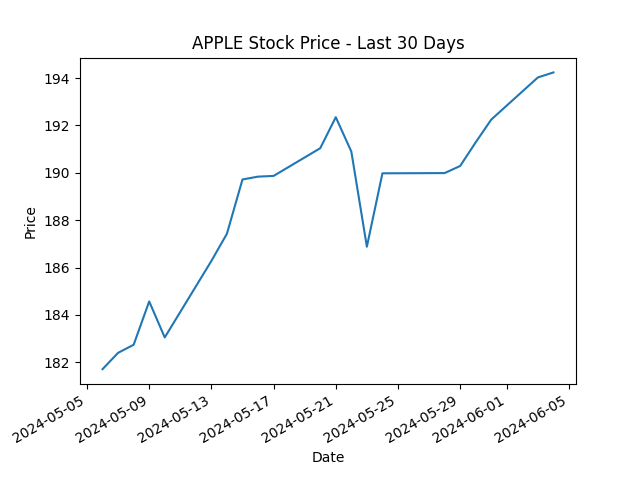

In [10]:
img = Image.open(os.path.join(WORK_DIR, 'apple.png'))
img

In [9]:
!ls $WORK_DIR/apple.png -lt

-rwxrwxrwx 1 root root 31032 Jun  4 15:01 workdir/apple.png


## 2. Multi agents cooperation

In [11]:
llm_config = {
    "cache_seed": None,
    "temperature": 0,
    "config_list": config_list,
}

In [12]:
financial_tasks = [
    """What are the current stock prices of SALESFORCE and GOOGLE, and how is the performance over the past 
    month in terms of percentage change?""",
    """Investigate possible reasons of the stock performance leveraging market news.""",
]

writing_tasks = [
    """Develop an engaging blog post using any information provided."""
]

In [13]:
financial_assistant = autogen.AssistantAgent(
    name="Financial_assistant",
    llm_config=llm_config,
)

research_assistant = autogen.AssistantAgent(
    name="Researcher",
    llm_config=llm_config,
)

writer = autogen.AssistantAgent(
    name="writer",
    llm_config=llm_config,
    system_message="""
        You are a professional writer, known for
        your insightful and engaging articles.
        You transform complex concepts into compelling narratives.
        Reply "TERMINATE" in the end when everything is done.
        """,
)

user_proxy_auto = autogen.UserProxyAgent(
    name="User_Proxy_Auto",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").
    rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": WORK_DIR,
        "use_docker": False,
    },  
)

user_proxy = autogen.UserProxyAgent(
    name="User_Proxy",
    human_input_mode="ALWAYS",  # ask human for input at each step
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").
    rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": WORK_DIR,
        "use_docker": False,
    }, 
)

chat_results = autogen.initiate_chats([
    {
        "sender": user_proxy_auto,
        "recipient": financial_assistant,
        "message": financial_tasks[0],
        "clear_history": True,
        "silent": False,
        "summary_method": "last_msg",
    },
    {
        "sender": user_proxy_auto,
        "recipient": research_assistant,
        "message": financial_tasks[1],
        "max_turns": 2,  
        "summary_method": "reflection_with_llm",
    },
    {
        "sender":
        user_proxy,
        "recipient":
        writer,
        "message":
        writing_tasks[0],
        "carryover":
        "I want to include a figure or a table of data in the blogpost.",  
    },
])


********************************************************************************
Starting a new chat....

********************************************************************************
User_Proxy_Auto (to Financial_assistant):

What are the current stock prices of SALESFORCE and GOOGLE, and how is the performance over the past 
    month in terms of percentage change?

--------------------------------------------------------------------------------
Financial_assistant (to User_Proxy_Auto):

To get the current stock prices and the performance over the past month, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance.

Here is the Python code to get the data:

```python
# Python code
import yfinance as yf
from datetime import datetime, timedelta

# Define the ticker symbols
tickers = ['CRM', 'GOOGL']  # CRM is the ticker for Salesforce, GOOGL for Google

# Get today's date and the date a month ago
today = datetime.today().strftim

writer (to User_Proxy):

Title: "Salesforce vs Google: A Tale of Two Tech Titans"

In the ever-evolving world of technology, two giants stand tall: Salesforce (CRM) and Google (GOOGL). Both have made significant strides in their respective fields, but their stock performances over the past month tell two very different stories. 

Salesforce, a global leader in customer relationship management (CRM) software, currently has a stock price of approximately $236.62. However, it has seen a decrease of about 14.15% over the past month. On the other hand, Google, the search engine behemoth, has a stock price of approximately $173.17, marking an increase of about 3.02% over the same period. 

[Insert Figure/Table Here: Comparative Stock Performance of Salesforce and Google]

It's important to note that these values are approximate and can vary slightly due to market fluctuations. But what could be the possible reasons behind these contrasting performances? 

To delve deeper into this, we've uti

In [14]:
for i, chat_res in enumerate(chat_results):
    print("-" * 100)
    print(f"{i+1}th chat:")
    print()
    print(chat_res.summary)
    print()
    print("1. Human input in the middle:", chat_res.human_input)
    print()
    print("2. Conversation cost: ", chat_res.cost)
    print()
    if i == 1:
        assert (
            len(chat_res.chat_history) == 4
        ), f"The chat history should contain at most 4 messages because max_turns is set to 2 in the {i}-th chat."

----------------------------------------------------------------------------------------------------
1th chat:

The current stock price of Salesforce (CRM) is approximately $236.62, and it has decreased by approximately 14.15% over the past month.

The current stock price of Google (GOOGL) is approximately $173.17, and it has increased by approximately 3.02% over the past month.

Please note that these values are approximate and can vary slightly due to market fluctuations.



1. Human input in the middle: []

2. Conversation cost:  {'usage_including_cached_inference': {'total_cost': 0.06636, 'gpt-4': {'cost': 0.06636, 'prompt_tokens': 1404, 'completion_tokens': 404, 'total_tokens': 1808}}, 'usage_excluding_cached_inference': {'total_cost': 0.06636, 'gpt-4': {'cost': 0.06636, 'prompt_tokens': 1404, 'completion_tokens': 404, 'total_tokens': 1808}}}

----------------------------------------------------------------------------------------------------
2th chat:

The assistant provided a Py

## Example 3

In [15]:
def my_writing_task(sender, recipient, context):
    carryover = context.get("carryover", "")
    if isinstance(carryover, list):
        carryover = carryover[-1]

    try:
        filename = context.get("work_dir", "") + "/stock_prices.md"
        with open(filename, "r") as file:
            data = file.read()
    except Exception as e:
        data = f"An error occurred while reading the file: {e}"

    return (
        """Develop an engaging blog post using any information provided. """ +
        "\nContext:\n" + carryover + "\nData:" + data)

In [16]:
research_task = """What are daily stock prices of NVDA and TESLA in the past month. Save the results in a .md file
 named 'stock_prices.md'."""

In [17]:
researcher = autogen.AssistantAgent(
    name="Financial_researcher",
    llm_config=llm_config,
)

writer = autogen.AssistantAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="""
        You are a professional writer, known for
        your insightful and engaging articles.
        You transform complex concepts into compelling narratives.
        Reply "TERMINATE" in the end when everything is done.
        """,
)

user_proxy_auto = autogen.UserProxyAgent(
    name="User_Proxy_Auto",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").
    rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": WORK_DIR,
        "use_docker": False,
    },
)

chat_results = autogen.initiate_chats([
    {
        "sender": user_proxy_auto,
        "recipient": researcher,
        "message": research_task,
        "clear_history": True,
        "silent": False,
        "summary_method": "last_msg",
    },
    {
        "sender": user_proxy_auto,
        "recipient": writer,
        "message": my_writing_task,
        "max_turns": 2,
        "summary_method": "reflection_with_llm",
        "work_dir": WORK_DIR,
    },
])


********************************************************************************
Starting a new chat....

********************************************************************************
User_Proxy_Auto (to Financial_researcher):

What are daily stock prices of NVDA and TESLA in the past month. Save the results in a .md file
 named 'stock_prices.md'.

--------------------------------------------------------------------------------
Financial_researcher (to User_Proxy_Auto):

To get the daily stock prices of NVDA and TESLA in the past month, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance.

Here is the Python code to do this:

```python
# filename: get_stock_prices.py

import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

# Define the ticker symbols
tickers = ['NVDA', 'TSLA']

# Define the date range (past month)
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

# Download the


--------------------------------------------------------------------------------
Writer (to User_Proxy_Auto):

# A Month in Review: NVDA and TESLA Stock Prices

In the world of stocks, every day brings a new story. The past month has been no different for two of the tech industry's giants, NVIDIA (NVDA) and Tesla (TSLA). Let's take a closer look at their performance over the past month.

## NVIDIA's Roller Coaster Ride

NVIDIA, a leading player in the GPU market, started the month at a closing price of $921.40 on May 6, 2024. The stock experienced a slight dip in the following days, reaching a low of $887.47 on May 9, 2024. However, this didn't last long as the stock began to climb again, reaching $913.56 by May 14, 2024.

The real excitement began on May 15, 2024, when the stock price shot up to $946.30. This upward trend continued, with the stock reaching a high of $1,148.25 on May 29, 2024. Despite a slight dip to $1,096.33 on May 31, 2024, NVIDIA ended the month on a high note, cl

In [18]:
!ls $WORK_DIR/stock_prices.md -lt

-rwxrwxrwx 1 root root 1559 Jun  4 15:13 workdir/stock_prices.md


In [20]:
with open(os.path.join(WORK_DIR, "stock_prices.md"), 'r') as file:
    markdowncontent = file.read()

display(Markdown(markdowncontent))

## NVDA
| Date                |    NVDA |
|:--------------------|--------:|
| 2024-05-06 00:00:00 |  921.4  |
| 2024-05-07 00:00:00 |  905.54 |
| 2024-05-08 00:00:00 |  904.12 |
| 2024-05-09 00:00:00 |  887.47 |
| 2024-05-10 00:00:00 |  898.78 |
| 2024-05-13 00:00:00 |  903.99 |
| 2024-05-14 00:00:00 |  913.56 |
| 2024-05-15 00:00:00 |  946.3  |
| 2024-05-16 00:00:00 |  943.59 |
| 2024-05-17 00:00:00 |  924.79 |
| 2024-05-20 00:00:00 |  947.8  |
| 2024-05-21 00:00:00 |  953.86 |
| 2024-05-22 00:00:00 |  949.5  |
| 2024-05-23 00:00:00 | 1037.99 |
| 2024-05-24 00:00:00 | 1064.69 |
| 2024-05-28 00:00:00 | 1139.01 |
| 2024-05-29 00:00:00 | 1148.25 |
| 2024-05-30 00:00:00 | 1105    |
| 2024-05-31 00:00:00 | 1096.33 |
| 2024-06-03 00:00:00 | 1150    |
| 2024-06-04 00:00:00 | 1143.03 |

## TSLA
| Date                |   TSLA |
|:--------------------|-------:|
| 2024-05-06 00:00:00 | 184.76 |
| 2024-05-07 00:00:00 | 177.81 |
| 2024-05-08 00:00:00 | 174.72 |
| 2024-05-09 00:00:00 | 171.97 |
| 2024-05-10 00:00:00 | 168.47 |
| 2024-05-13 00:00:00 | 171.89 |
| 2024-05-14 00:00:00 | 177.55 |
| 2024-05-15 00:00:00 | 173.99 |
| 2024-05-16 00:00:00 | 174.84 |
| 2024-05-17 00:00:00 | 177.46 |
| 2024-05-20 00:00:00 | 174.95 |
| 2024-05-21 00:00:00 | 186.6  |
| 2024-05-22 00:00:00 | 180.11 |
| 2024-05-23 00:00:00 | 173.74 |
| 2024-05-24 00:00:00 | 179.24 |
| 2024-05-28 00:00:00 | 176.75 |
| 2024-05-29 00:00:00 | 176.19 |
| 2024-05-30 00:00:00 | 178.79 |
| 2024-05-31 00:00:00 | 178.08 |
| 2024-06-03 00:00:00 | 176.29 |
| 2024-06-04 00:00:00 | 174.77 |



In [21]:
# Display the plain text version of the Markdown content
plain_text = markdowncontent.replace("**", "").replace("[", "").replace("]", "")
print(plain_text)

## NVDA
| Date                |    NVDA |
|:--------------------|--------:|
| 2024-05-06 00:00:00 |  921.4  |
| 2024-05-07 00:00:00 |  905.54 |
| 2024-05-08 00:00:00 |  904.12 |
| 2024-05-09 00:00:00 |  887.47 |
| 2024-05-10 00:00:00 |  898.78 |
| 2024-05-13 00:00:00 |  903.99 |
| 2024-05-14 00:00:00 |  913.56 |
| 2024-05-15 00:00:00 |  946.3  |
| 2024-05-16 00:00:00 |  943.59 |
| 2024-05-17 00:00:00 |  924.79 |
| 2024-05-20 00:00:00 |  947.8  |
| 2024-05-21 00:00:00 |  953.86 |
| 2024-05-22 00:00:00 |  949.5  |
| 2024-05-23 00:00:00 | 1037.99 |
| 2024-05-24 00:00:00 | 1064.69 |
| 2024-05-28 00:00:00 | 1139.01 |
| 2024-05-29 00:00:00 | 1148.25 |
| 2024-05-30 00:00:00 | 1105    |
| 2024-05-31 00:00:00 | 1096.33 |
| 2024-06-03 00:00:00 | 1150    |
| 2024-06-04 00:00:00 | 1143.03 |

## TSLA
| Date                |   TSLA |
|:--------------------|-------:|
| 2024-05-06 00:00:00 | 184.76 |
| 2024-05-07 00:00:00 | 177.81 |
| 2024-05-08 00:00:00 | 174.72 |
| 2024-05-09 00:00:00 | 171.97 |
| 2